# Imports

In [2]:
using NLsolve
using LinearAlgebra
using Random
using RandomMatrices

In [3]:
import PyPlot
const plt = PyPlot;

# setup

In [4]:
# found here: https://groups.google.com/g/julia-users/c/BswpTOoHdfA
# lexicographic premutations generation, By Donald Knuth  
function lpermutations(a)
    b = Vector()
    sort!(a)
    n = length(a)
    while(true)
        push!(b, copy(a))    
        j = n-1
        while(a[j] >= a[j+1])
            j -= 1
            j == 0 && return(b)
        end
        l=n
        while(a[j] >= a[l])
            l -= 1
        end
        tmp = a[l]
        a[l] = a[j]
        a[j] = tmp
        k = j+1
        l = n
        while(k < l)
            tmp = a[k]
            a[k] = a[l]
            a[l] = tmp
            k += 1
            l -= 1
        end
    end
end

"""
    generate_basis_state(N::Int, j::Int, k::Int)

Generate basis column vector of length `N` with `j` excitations (assuming at most one excitation per channel).
`1 ≤ k ≤ binomial(N, j)` is a unique basis state in the `j`-excitation manifold.
"""
function generate_basis_state(N::Int, j::Int, k::Int)
    state = zeros(Int, N)
    length = binomial(N, j)
    @assert j ≤ N "j > N (we assume one excitation per input at most)"
    @assert 1 ≤ k ≤ length "k<1 or k>binomial(N, j)"
    for i in 1:j
        state[i] = 1
    end
    # return state
    return convert(Vector{ComplexF64}, lpermutations(state)[k])
end

generate_basis_state

In [5]:
"""
    reference_plot(N; colors=false, save_plot_as=nothing, figsize=5, io_labels=true, grid=false)

Plot the beam splitter geometry for a Clements decomposition of an arbitrary N×N unitary.
"""
function reference_plot(N; colors=false, save_plot_as=nothing, figsize=5, io_labels=true, grid=false)
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    # function annotate(i, j, x, y)
    #     text = plt.annotate(
    #         L"$T_{$i$j}$", (x, y), color="red", zorder=10,
    #         bbox=Dict([("boxstyle", "rarrow,pad=0.3"), ("fc", "white"), ("ec", "r"), ("lw", 2)])
    #     )
    #     text.set_rotation(45)
    # end
    
    # construct line segments
    lines = []
    for i in 1:N
        line = [(0, -i*1.), (1/2, -i)]
        if i%2 == 0 || i == N
            if i == N
                if N%2 == 1
                    push!(line, (3/2, -i), (N+1/2, -1))
                else
                    push!(line, (N-1/2, -1))
                end
            else
                push!(line, (0, -i*1.), (1/2, -i), (i, -1/2), (N+1/2, -N+i-1))
            end
        else
            if i == 1
                push!(line, (N-1/2, -N))
            else
                push!(line, (N-i+1, -N-1/2), (N+1/2, -N+i-1))
            end
        end
        push!(line, (N+1, -N+i-1))
        push!(lines, line)
    end
    
    # setup plot configs
    mc = plt.matplotlib.collections
    if colors
        colors = [plt.matplotlib.colors.to_rgba(c) for c in plt.matplotlib.rcParams["axes.prop_cycle"].by_key()["color"]]
        lc = mc.LineCollection(lines, color=colors, linewidths=2)
    else
        lc = mc.LineCollection(lines, color="k", linewidths=2)
    end
    ax.add_collection(lc)
    plt.gca().set_aspect("equal")
    ax.set_xticklabels([])
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    ax.spines["bottom"].set_visible(false)
    ax.spines["left"].set_visible(false)
    plt.tick_params(bottom=false, left=false)
    if io_labels
        ax.set_yticks(collect(-1:-1:-N))
        ax.set_yticklabels(collect(N:-1:1))
        ax.tick_params(labelright=true)
        pad = -20 / 5 * figsize
        ax.yaxis.set_tick_params(pad=pad)
    else
        ax.set_yticklabels([])
    end
    ax.margins(0.1)
    if grid
        plt.grid(grid)
        ax.set_xticks(collect(1:N))
        plt.ylim(-1/2, -(N + 1/2))
    end
    if !isnothing(save_plot_as)
        plt.savefig(save_plot_as)
    end
end

reference_plot

In [70]:
# https://stackoverflow.com/questions/37101324/how-to-zero-out-small-values-in-an-array#answer-37101609
function sparsify(x, eps) 
    if abs(x) < eps
        return 0.0
    elseif abs(real(x)) < eps
        return imag(x) * 1im
    elseif abs(imag(x)) < eps
        return real(x)
    end
    return x
end

function sparsify(x) 
    eps = 1e-8
    if abs(x) < eps
        return 0.0
    elseif abs(real(x)) < eps
        return imag(x) * 1im
    elseif abs(imag(x)) < eps
        return real(x)
    end
    return x
end

##################################################################################################################################
# Convenience functions for computing Tₘₙ(θ,ϕ) and Tₘₙ⁻¹(θ,ϕ) as defined in http://dx.doi.org/10.1364/OPTICA.3.001460 for n=m+1
##################################################################################################################################
function Tdiagonal(N, m, θ, ϕ; inv=false)
    values = ones(ComplexF64, N)
    values[m] = exp(1im * (-1)^Int(inv) * ϕ) * cos(θ)
    values[m+1] = cos(θ)
    return values
end

function Tlowerdiagonal(N, m, θ, ϕ; inv=false)
    values = zeros(ComplexF64, N-1)
    if inv
        values[m] = -sin(θ)
    else
        values[m] = exp(1im * ϕ) * sin(θ)
    end
    return values
end

function Tupperdiagonal(N, m, θ, ϕ; inv=false)
    values = zeros(ComplexF64, N-1)
    if inv
        values[m] = exp(-1im * ϕ) * sin(θ)
    else   
        values[m] = -sin(θ)
    end
    return values
end

"""
    Tmn(N::Int, m::Int, θ::Real, ϕ::Real; inv::Bool=false)

Compute Tₘₙ(θ,ϕ) of dimension N×N (or Tₘₙ⁻¹(θ,ϕ) when `inv=true`) as described in [this paper](http://dx.doi.org/10.1364/OPTICA.3.001460) when `n=m+1`.
"""
function Tmn(N::Int, m::Int, θ::Real, ϕ::Real; inv::Bool=false)
    diagm(0 => Tdiagonal(N, m, θ, ϕ, inv=inv), 
         -1 => Tlowerdiagonal(N, m, θ, ϕ, inv=inv), 
          1 => Tupperdiagonal(N, m, θ, ϕ, inv=inv)
    )
end

function Tmn(N::Int, m::Int, n::Int, θ::Real, ϕ::Real; inv::Bool=false)
    T = diagm(0 => Complex[1. for _ in 1:N])
    T[m, m] = exp(1im * (-1)^Int(inv) * ϕ) * cos(θ)
    T[n, n] = cos(θ)
    if inv
        T[m, n] = exp(-1im * ϕ) * sin(θ)
        T[n, m] = -sin(θ)
    else
        T[m, n] = -sin(θ)
        T[n, m] = exp(1im * ϕ) * sin(θ)
    end
    return T
end

function Tmn(N::Int, m::Int, n::Int, θ::Real, ϕ::Real; inv::Bool=false, T::Array{Complex}=diagm(0 => Complex[1. for _ in 1:N]))
    T .= diagm(0 => Complex[1. for _ in 1:N])
    T[m, m] = exp(1im * (-1)^Int(inv) * ϕ) * cos(θ)
    T[n, n] = cos(θ)
    if inv
        T[m, n] = exp(-1im * ϕ) * sin(θ)
        T[n, m] = -sin(θ)
    else
        T[m, n] = -sin(θ)
        T[n, m] = exp(1im * ϕ) * sin(θ)
    end
    return T
end

##################################################################################################################################
# Convenience functions for computing appropriate nulling θ, ϕ for Tₘₙ(θ,ϕ) and Tₘₙ⁻¹(θ,ϕ) as defined in 
# http://dx.doi.org/10.1364/OPTICA.3.001460
##################################################################################################################################

# F[1] (F[2]) are the real (imaginary) expressions for [Tₘₙ(θ,ϕ)×U]ₖₗ
function f!(F, x, k::Int, l::Int, u1::Complex, u2::Complex)
    θ = x[1]
    ϕ = x[2]
    F[1] = real(u1) * cos(ϕ) * sin(θ) - imag(u1) * sin(ϕ) * sin(θ) + real(u2) * cos(θ)
    F[2] = real(u1) * sin(ϕ) * sin(θ) + imag(u1) * cos(ϕ) * sin(θ) + imag(u2) * cos(θ) 
end

# The Jacobian for the system of equations described by F[1], F[2] in f! as a function of θ, ϕ
function j!(J, x, k::Int, l::Int, u1::Complex, u2::Complex)
    θ = x[1]
    ϕ = x[2]
    J[1, 1] =  real(u1) * cos(ϕ) * cos(θ) - imag(u1) * sin(ϕ) * cos(θ) - real(u2) * sin(θ)
    J[1, 2] = -real(u1) * sin(ϕ) * sin(θ) - imag(u1) * cos(ϕ) * sin(θ)
    J[2, 1] =  real(u1) * sin(ϕ) * cos(θ) + imag(u1) * cos(ϕ) * cos(θ) - imag(u2) * sin(θ)
    J[2, 2] =  real(u1) * cos(ϕ) * sin(θ) - imag(u1) * sin(ϕ) * sin(θ)
end

# F[1] (F[2]) are the real (imaginary) expressions for [U×Tₘₙ⁻¹(θ,ϕ)]ₖₗ
function finv!(F, x, k::Int, l::Int, u1::Complex, u2::Complex)
    θ = x[1]
    ϕ = x[2]
    F[1] =  real(u1) * cos(ϕ) * cos(θ) + imag(u1) * sin(ϕ) * cos(θ) - real(u2) * sin(θ)
    F[2] = -real(u1) * sin(ϕ) * cos(θ) + imag(u1) * cos(ϕ) * cos(θ) - imag(u2) * sin(θ)
end

# The Jacobian for the system of equations described by F[1], F[2] in finv! as a function of θ, ϕ
function jinv!(J, x, k::Int, l::Int, u1::Complex, u2::Complex)
    θ = x[1]
    ϕ = x[2]
    J[1, 1] = -real(u1) * cos(ϕ) * sin(θ) - imag(u1) * sin(ϕ) * sin(θ) - real(u2) * cos(θ)
    J[1, 2] = -real(u1) * sin(ϕ) * cos(θ) + imag(u1) * cos(ϕ) * cos(θ)
    J[2, 1] =  real(u1) * sin(ϕ) * sin(θ) - imag(u1) * cos(ϕ) * sin(θ) - imag(u2) * cos(θ)
    J[2, 2] = -real(u1) * cos(ϕ) * cos(θ) - imag(u1) * sin(ϕ) * cos(θ)
end

"""
    clements_decomposition(U::Array{<:Complex})

Takes an arbitrary unitary and decomposes it into elementary beam splitter operations according to the 
[Clements algorithm](http://dx.doi.org/10.1364/OPTICA.3.001460). Returns a tuple with the first element
a diagonal matrix `D` describing some combination of single mode phase shifts and  a list of tuples
specificying elementary beam splitter operations `(m, n=m+1, θ, ϕ)` (see ref) such that one may construct
`U = D × .. × Tₘₙ(θ, ϕ).
"""
function clements_decomposition(U::Array{<:Complex}; p0=[0, π])
    N, M = size(U)
    right_multipliers = []
    left_multipliers = []
    reverse_left_multipliers = []
    @assert N == M && U * U' ≈ diagm(0 => [1 for i in 1:N]) "only implemented for unitary arrays"
    Uc = copy(U)
    # T = diagm(0 => Complex[1. for _ in 1:N])
    for i in 1:N-1, j in 1:i
        θ, ϕ = 0., 0.
        if i%2 == 1
            m = i - j + 1
            n = m + 1
            k = N - j + 1
            l = m
            # Solve for Tₘₙ⁻¹(θ,ϕ) such that [U×Tₘₙ⁻¹(θ,ϕ)]ₖₗ = 0
            if abs(Uc[k, l]) > 1e-6
                u1 = Uc[k, l]
                u2 = Uc[k, l+1]
                s = nlsolve((F, x) -> finv!(F, x, k, l, u1, u2), (J, x) -> jinv!(J, x, k, l, u1, u2), p0)
                @assert s.f_converged "Solver failed to converge when nulling U_{$k, $l}."
                θ, ϕ = s.zero
                θ = θ #% (π/2)
                ϕ = ϕ #% (2π)
            end
            push!(right_multipliers, (m, n, θ, ϕ))
            Uc = Uc * Tmn(N, m, θ, ϕ, inv=true)
        else
            m = N - i + j - 1
            n = m + 1
            k = n
            l = j
            # Solve for Tₘₙ(θ,ϕ) such that [Tₘₙ(θ,ϕ)×U]ₖₗ = 0
            if abs(Uc[k, l]) > 1e-6
                u1 = Uc[k-1, l]
                u2 = Uc[k, l]
                s = nlsolve((F, x) -> f!(F, x, k, l, u1, u2), (J, x) -> j!(J, x, k, l, u1, u2), p0)
                @assert s.f_converged "Solver failed to converge when nulling U_{$k, $l}."
                θ, ϕ = s.zero
                θ = θ #% (π/2)
                ϕ = ϕ #% (2π)
            end
            push!(left_multipliers, (m, n, θ, ϕ))
            Uc = Tmn(N, m, θ, ϕ, inv=false) * Uc
        end
    end
    for multiplier in reverse(left_multipliers)
        m, n, θ, ϕ1 = multiplier
        φ1 = atan(imag(Uc[m, m]), real(Uc[m, m]))
        φ2 = atan(imag(Uc[n, n]), real(Uc[n, n]))
        Uc[m, m] = exp(1im * (φ2 - ϕ1 + π))
        ϕ2 = φ1 - π - φ2
        push!(reverse_left_multipliers, (m, n, θ, ϕ2))
    end
    return Uc, vcat(right_multipliers, reverse_left_multipliers)
end

clements_decomposition

# calculations

## Test

In [128]:
dim = 20
d = Haar(2)
R = rand(d, dim);

In [129]:
@time D, c = clements_decomposition(R); sparsify.(D, 1e-6)

  0.047507 seconds (59.54 k allocations: 5.147 MiB, 59.62% gc time)


20×20 Matrix{Number}:
 0.999919-0.0127251im           0.0          …           0.0
         0.0           -0.828911-0.559381im              0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0          …           0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0          …           0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0                      0.0
         0.0                    0.0          …           0.0
  

In [130]:
M = diagm(0 => ones(Complex, dim))
println("(m,n)   refl.  ϕ")
println("----------------------------")
for (l, i) in enumerate(c)
    println(" $(i[1]),$(i[1] + 1):   $(round(cos(i[3])^2, digits=2)),  ($(rationalize(round(i[4]/π, digits=3))))π")
    M = Tmn(dim, i[1], i[3], i[4]) * M
end

(m,n)   refl.  ϕ
----------------------------
 1,2:   0.86,  (417//500)π
 3,4:   0.89,  (211//250)π
 2,3:   0.4,  (197//200)π
 1,2:   0.08,  (111//125)π
 5,6:   0.84,  (561//500)π
 4,5:   0.16,  (4617//1000)π
 3,4:   0.09,  (1139//1000)π
 2,3:   0.09,  (57//50)π
 1,2:   0.14,  (1279//1000)π
 7,8:   0.77,  (619//500)π
 6,7:   0.32,  (113//200)π
 5,6:   0.07,  (529//1000)π
 4,5:   0.1,  (79//125)π
 3,4:   0.15,  (829//1000)π
 2,3:   0.42,  (951//1000)π
 1,2:   0.28,  (151//125)π
 9,10:   0.33,  (1193//1000)π
 8,9:   0.05,  (979//1000)π
 7,8:   0.03,  (247//200)π
 6,7:   0.29,  (359//250)π
 5,6:   0.13,  (-3341//1000)π
 4,5:   0.04,  (1387//1000)π
 3,4:   0.03,  (871//1000)π
 2,3:   0.12,  (727//1000)π
 1,2:   0.19,  (2727//500)π
 11,12:   0.24,  (797//1000)π
 10,11:   0.17,  (529//1000)π
 9,10:   0.04,  (381//500)π
 8,9:   0.18,  (-31//25)π
 7,8:   0.1,  (143//125)π
 6,7:   0.12,  (1747//500)π
 5,6:   0.11,  (103//100)π
 4,5:   0.27,  (1193//1000)π
 3,4:   0.1,  (123//200)π
 2,3:   0.13,

In [137]:
sparsify.(D * M - R)

20×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [136]:
norm(D * M - R)

6.08955397555701e-8

## Decompose symmetric 4-port beam splitter unitary

In [142]:
# Symmetric 4-port beam splitters are constrained to the following form

ϕv = 0
U = ComplexF64[
    1         1         1         1
    1   exp(1im * ϕv)  -1  -exp(1im * ϕv)
    1        -1         1        -1
    1  -exp(1im * ϕv)  -1   exp(1im * ϕv)
]/2; sparsify.(U)

4×4 Matrix{Float64}:
 0.5   0.5   0.5   0.5
 0.5   0.5  -0.5  -0.5
 0.5  -0.5   0.5  -0.5
 0.5  -0.5  -0.5   0.5

In [167]:
dim = size(U)[1]
D, c = clements_decomposition(U, p0=[0.1, 0.15]); sparsify.(D, 1e-6)

4×4 Matrix{Float64}:
 1.0  0.0   0.0  0.0
 0.0  1.0   0.0  0.0
 0.0  0.0  -1.0  0.0
 0.0  0.0   0.0  1.0

In [168]:
M = diagm(0 => ones(Complex, dim))
println("(m,n)   refl.  ϕ")
println("----------------------------")
for (l, i) in enumerate(c)
    println(" $(i[1]),$(i[1] + 1):   $(round(cos(i[3])^2, digits=2)),  ($(rationalize(round(i[4]/π, digits=3))))π")
    M = Tmn(dim, i[1], i[3], i[4]) * M
end

(m,n)   refl.  ϕ
----------------------------
 1,2:   0.5,  (0//1)π
 3,4:   0.5,  (0//1)π
 2,3:   0.0,  (6//125)π
 1,2:   0.5,  (0//1)π
 3,4:   0.5,  (-6//125)π
 2,3:   1.0,  (0//1)π


In [166]:
sparsify.(D * M)

4×4 Matrix{Float64}:
 0.5   0.5   0.5   0.5
 0.5   0.5  -0.5  -0.5
 0.5  -0.5   0.5  -0.5
 0.5  -0.5  -0.5   0.5

In [161]:
norm(D * M - U)

3.702701482014036e-14

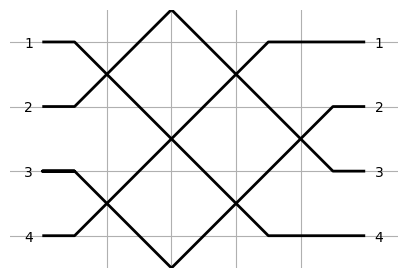

In [17]:
reference_plot(4, colors=false, save_plot_as=nothing, io_labels=true, figsize=5, grid=true)

## Construct unitary as illustrated in poster

In [ ]:
U_poster = 
Tmn(4, 2, 3, acos(√2/3), 0) *
Tmn(4, 1, 3, acos(√1/4), 0) *
Tmn(4, 2, 4, acos(√1/4), 0) *
Tmn(4, 2, acos(√1/3), 0) *
Tmn(4, 3, acos(√1/2), 0) *
Tmn(4, 1, acos(√1/2), 0)

4×4 Matrix{Any}:
 -0.665569+0.0im  -0.672942+0.0im  -0.161374+0.0im    0.279508+0.0im
 -0.572956+0.0im   0.655217+0.0im  -0.487587+0.0im  -0.0683458+0.0im
   0.38809+0.0im  -0.302983+0.0im  -0.823803+0.0im   -0.280956+0.0im
  0.279508+0.0im   0.161374+0.0im  -0.239929+0.0im    0.915569+0.0im

In [ ]:
sparsify.(U - U_poster)

4×4 Matrix{Number}:
 1.16557            1.17294    0.661374            0.220492
 1.07296   -0.655217+0.5im    -0.0124132  0.0683458-0.5im
 0.11191           -0.197017   1.3238             -0.219044
 0.220492  -0.161374-0.5im    -0.260071   -0.915569+0.5im

In [670]:
U_alt = 
Tmn(4, 2, 3, π, -π) *
Tmn(4, 3, 4, π/4, -π/2) *
Tmn(4, 1, 2, π/4, π) *
Tmn(4, 2, 3, π/2, π/2) *
Tmn(4, 3, 4, π/4, π) *
Tmn(4, 1, 2, π/4, π) 

4×4 Matrix{Any}:
  0.5-9.18485e-17im   0.5-9.18485e-17im  …  -0.5+0.0im
  0.5-9.18485e-17im   0.5+3.06162e-17im      0.5+6.12323e-17im
  0.5-6.12323e-17im  -0.5-3.7494e-33im       0.5-3.06162e-17im
 -0.5+6.12323e-17im   0.5+0.0im              0.5+3.06162e-17im

In [671]:
sparsify.(D * U_alt)

4×4 Matrix{Float64}:
  0.5   0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5
  0.5  -0.5  -0.5   0.5
 -0.5   0.5  -0.5   0.5

In [672]:
sparsify.(U_alt * U_alt')

4×4 Matrix{Float64}:
 1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0